In [1]:
pip install trimesh

In [2]:
import os
import random
import glob
import trimesh
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import scipy 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv3D, Dense ,Dropout, Flatten, Activation, MaxPooling3D, Input
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM


from sklearn.model_selection import train_test_split, KFold,StratifiedKFold

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt


In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    print("reading from cloud...")
    path = "/content/drive/MyDrive/Colab Notebooks/MPPE/data_70p_overhang/stls_opt/"
    path_vox = "/content/drive/MyDrive/Colab Notebooks/MPPE/data_70p_overhang/voxelsFloat/"
    
except:
    import pathlib
    print("reading from disk")
    path = str(pathlib.Path().resolve())+"/dataset/stls_opt/"
    path_vox = str(pathlib.Path().resolve())+"/dataset/voxels/"


mesh = trimesh.load(path+"63_8475_10313_17790_28845.stl")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
reading from cloud...


In [4]:
def calculate_cost(filename):
  #params
  #time - parts usally need 15 minutes for preparation
  #1h - 10eur
  price_per_h = 2
  price_per_meter = 0.17#0.1133 #150 meters costs 17e 
  filament_diameter = 2.85 #mm
  filament_phi = np.power(filament_diameter/2,2)*np.pi #mm^2
  
  support_removal_multiplier= 2
  support_removal_multiplier_time = 1.5
  profit_margin = 0.1
  #larger parts need longer time + 5 minutes slice time. 
  
  #get data from filename
  data = filename.replace(".","_").split("_")
  data = [int(x) for x in data[:-1]]

  #calculate cost from filament lenght

  #calulate cost no support 
  cost_filament = ((data[2]/(filament_phi*1000)))*price_per_meter

  #calulcate cost of printing supports only 
  cost_supports = (abs(data[2]-data[4])/(filament_phi*1000))*price_per_meter
  cost_supports_removal = support_removal_multiplier*cost_supports

  #calulate timewise cost in hours
  print_time = data[1]
  print_time_supports = data[3]

  #convert to horus and include time for removing supports 
  print_time= (((print_time + 2*abs(print_time-print_time_supports))*support_removal_multiplier_time)/3600)
  print_time_cost = print_time * price_per_h

  #cena
  cost = (cost_filament+cost_supports+cost_supports_removal+print_time_cost)
  cost = (cost*profit_margin)+cost

  return cost

#cost = calculate_cost("89_88123_134991_106833_152824.stl")
#cost = calculate_cost("62_1605_2129_2398_3618.stl")
cost = calculate_cost("108_31956_48635_34435_50936.stl")
print(cost)

35.46582523917991


In [15]:
X = np.zeros([0,100,100,100])
X_volume = np.zeros([0,1])
X_area = np.zeros([0,1])

y = np.zeros(0)
count = 0
for filename in os.listdir(path_vox):
    if filename.endswith(".npy"):
        count = count +1
        #print("appending", filename.split(".")[0])
        img = np.load(path_vox+filename)

        img =(img -(np.min(img)))
        img = img/np.max(img)
        cost = calculate_cost(filename)
        
        img = np.swapaxes(img,0,-1)

        X = np.append(X,img[np.newaxis,...],axis=0)
        y = np.append(y,cost)
        
        mesh = trimesh.load(path+filename.split(".")[0]+".stl")
        
        mv = np.array(abs(mesh.volume))
        X_volume = np.append(X_volume,mv[np.newaxis,...])

        ma = np.array(abs(mesh.area))
        X_area = np.append(X_area,ma[np.newaxis,...])

print(count)
X_area = X_area[...,np.newaxis]
X_volume = X_volume[...,np.newaxis]
X = X[...,np.newaxis]

194


In [16]:
n_samples = X.shape[0]
train_ind, test_ind  = train_test_split(range(n_samples), test_size=0.2, random_state=36)

X_train = X[train_ind]
X_train_volume = X_volume[train_ind]
X_train_area = X_area[train_ind]
y_train = y[train_ind]

X_test = X[test_ind]
X_test_volume = X_volume[test_ind]
X_test_area = X_area[test_ind]
y_test = y[test_ind]

print("train",X_train.shape,X_train_volume.shape,X_train_area.shape)
print("test",X_test.shape,X_test_volume.shape,X_test_area.shape)

train (155, 100, 100, 100, 1) (155, 1) (155, 1)
test (39, 100, 100, 100, 1) (39, 1) (39, 1)


In [22]:
def augment(img,angle):

  img = scipy.ndimage.rotate(img,angle,axes=(0,1),order=3)
  n = 100
  desiredshape = np.array([n,n,n])
  zoomArray = desiredshape.astype(np.float32) / img.shape
  img = scipy.ndimage.interpolation.zoom(img, zoomArray).astype(np.float32)
  
  img =(img -(np.min(img)))

  img = img/np.max(img)
  return img

In [23]:
X_train_2 = np.zeros([0,100,100,100])
X_train_volume_2 = np.zeros([0,1])
X_train_area_2 = np.zeros([0,1])
y_train_2 = np.zeros(0)

for i,img in enumerate(X_train):
  for angle in range(0,330,30):
    img_aug = augment(img[:,:,:,0],angle)

    X_train_2 = np.append(X_train_2,img_aug[np.newaxis,...],axis=0)
    X_train_volume_2 = np.append(X_train_volume_2,X_train_volume[i])
    X_train_area_2 = np.append(X_train_area_2,X_train_area[i])

    y_train_2 = np.append(y_train_2,y_train[i])
  
X_train_area_2 = X_train_area_2[...,np.newaxis]
X_train_volume_2 = X_train_volume_2[...,np.newaxis]
X_train_2 = X_train_2[...,np.newaxis]

KeyboardInterrupt: ignored

In [ ]:
X_train = X_train_2
X_trian_volume = X_train_2
X_train_area_2 = X_train_area
y_train = y_train_2

In [87]:

#my net
input1 = keras.Input(shape=(X_train.shape[1:]))
input2 = keras.Input(shape=(X_train_volume.shape[1:]))
input3 = keras.Input(shape=(X_train_area.shape[1:]))

#y = Dense(1)(input2)
activ = "relu"
# x = Conv3D(63,(3,3,3),strides = (2,2,2), activation=activ, padding = 'same')(input1)
# x = Conv3D(64,(3,3,3),strides = (2,2,2), activation=activ, padding = 'same')(x)
# x = MaxPooling3D(pool_size=(2, 2, 2))(x)
#x = layers.Dropout(0.3)(x)
n=3
x = Conv3D(16,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(input1)
x = Conv3D(16,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
#x = layers.Dropout(0.3)(x)
x = Conv3D(8,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
x = Conv3D(8,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)

# x = Conv3D(8,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
# x = Conv3D(8,(n,n,n),strides = (2,2,2), activation=activ, padding = 'same')(x)
# x = MaxPooling3D(pool_size=(1, 1, 1))(x)

x = Activation('relu')(x)

x = layers.Dropout(0.3)(x)

x = Flatten()(x)

x = layers.Concatenate(axis=1)([x,input2])
x = layers.Concatenate(axis=1)([x,input2*2])
x = layers.Concatenate(axis=1)([x,input2*3])
x = layers.Concatenate(axis=1)([x,input2*4])
x = layers.Concatenate(axis=1)([x,input2*5])
x = layers.Concatenate(axis=1)([x,input2*6])
x = layers.Concatenate(axis=1)([x,input2*7])

#x = Dense(4, activation = 'relu')(x)
x = layers.Concatenate(axis=1)([x,input3])

dense = Dense(2000, activation = activ)(x)
dense = Dense(300, activation = activ)(dense)
dense = Dense(150, activation = activ)(dense)
dense = Dense(20, activation = activ)(dense)
dense = Dense(16, activation = activ)(dense)
    # final layer with 10 neurons to classify the instances
output = Dense(1, activation = 'linear')(dense)
    
#outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=[input1,input2,input3], outputs=output, name="jjnet")

In [23]:
input1 = keras.Input(shape=(X_train.shape[1:]))
input2 = keras.Input(shape=(X_train_volume.shape[1:]))
input3 = keras.Input(shape=(X_train_area.shape[1:]))

activ = "relu"

x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input1)
x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)

x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = TimeDistributed(Convolution2D(4, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(Convolution2D(4, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = Dropout(0.30)(x)

x = TimeDistributed(Convolution2D(4, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(Convolution2D(4, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
x = Dropout(0.60)(x)
x = TimeDistributed(Flatten())(x)
x = LSTM(8, return_sequences=True, unroll=False, dropout=0.3)(x)  # dropout=0.6
x = LSTM(8, return_sequences=False, unroll=False, dropout=0.3)(x)


x = layers.Concatenate(axis=1)([x,input2])

#x = Dense(4, activation = 'relu')(x)
x = layers.Concatenate(axis=1)([x,input3])

dense = Dense(2000, activation = activ)(x)
dense = Dense(300, activation = activ)(dense)
dense = Dense(150, activation = activ)(dense)
dense = Dense(20, activation = activ)(dense)
dense = Dense(16, activation = activ)(dense)
    # final layer with 10 neurons to classify the instances
output = Dense(1, activation = 'linear')(dense)
    

model = keras.Model(inputs=[input1,input2,input3], outputs=output, name="jjlstmnet")


In [ ]:
#@title Default title text
#paper net 
input1 = keras.Input(shape=(X_train.shape[1:]))
input2 = keras.Input(shape=(X_train_volume.shape[1:]))
input3 = keras.Input(shape=(X_train_area.shape[1:]))



x = Conv3D(16,(3,3,3), activation='LeakyReLU', padding = 'same')(input1)
x = Conv3D(16,(3,3,3), activation='LeakyReLU', padding = 'same')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = layers.Dropout(0.3)(x)

x = Conv3D(32,(3,3,3), activation='LeakyReLU', padding = 'same')(x)
x = Conv3D(32,(3,3,3), activation='LeakyReLU', padding = 'same')(x)
x = MaxPooling3D(pool_size=(2, 2, 2))(x)
x = layers.Dropout(0.3)(x)

x = Conv3D(8,(3,3,3), activation='LeakyReLU', padding = 'same')(x)

x = layers.Dropout(0.8)(x)

x = Flatten()(x)

x = layers.Concatenate(axis=1)([x,input2])
x = Dense(8, activation = 'LeakyReLU')(x)
dense = Dense(2000, activation = 'LeakyReLU')(x)
dense = Dense(300, activation = 'LeakyReLU')(dense)
dense = Dense(150, activation = 'LeakyReLU')(dense)
dense = Dense(20, activation = 'LeakyReLU')(dense)
dense = Dense(16, activation = 'LeakyReLU')(dense)
    # final layer with 10 neurons to classify the instances
output = Dense(1, activation = 'linear')(dense)
    
#outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=[input1,input2], outputs=output, name="papernet")

In [ ]:
model.compile(
    loss="MAE",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["MAPE"],
)

model.fit([X_train,np.log(X_train_volume), np.log(X_train_area)], np.log(y_train),validation_split = 0.2, batch_size = 8, epochs = 100, verbose = 1)


Epoch 1/100
16/16 [==============================] - 63s 3s/step - loss: 2.6567 - MAPE: 99.9337 - val_loss: 2.4298 - val_MAPE: 99.8492
Epoch 2/100
16/16 [==============================] - 23s 1s/step - loss: 2.6511 - MAPE: 99.9022 - val_loss: 2.4279 - val_MAPE: 99.6209
Epoch 3/100
16/16 [==============================] - 23s 1s/step - loss: 2.6498 - MAPE: 99.7361 - val_loss: 2.4265 - val_MAPE: 99.4465
Epoch 4/100
16/16 [==============================] - 23s 1s/step - loss: 2.6486 - MAPE: 99.6593 - val_loss: 2.4251 - val_MAPE: 99.2597
Epoch 5/100
16/16 [==============================] - 24s 1s/step - loss: 2.6473 - MAPE: 99.5151 - val_loss: 2.4236 - val_MAPE: 99.0731
Epoch 6/100
16/16 [==============================] - 23s 1s/step - loss: 2.6460 - MAPE: 99.4910 - val_loss: 2.4221 - val_MAPE: 98.8857
Epoch 7/100
16/16 [==============================] - 23s 1s/step - loss: 2.6448 - MAPE: 99.3941 - val_loss: 2.4204 - val_MAPE: 98.6770
Epoch 8/100
16/16 [==============================] - 23

In [19]:
preds = model.predict([X_test, np.log(X_test_volume),np.log(X_test_area)])#*y_train_max

In [20]:
np.sum(abs(np.exp(preds)-(y_test)))/len(preds)

1011.7132990542905

In [21]:
np.sum(abs(((preds)-(np.log(y_train)))))/len(preds)

257.2425374265802

In [22]:
for e,i in zip(np.exp(preds),y_test):
  print("preds",e,"truth",i)

preds [3.0069158] truth 10.550534009106135
preds [0.6692073] truth 0.876478508911503
preds [39.306473] truth 37.825807515098546
preds [9.647889] truth 9.558691957739363
preds [13.491415] truth 11.33614703354167
preds [14.118501] truth 8.992949423767875
preds [18.467197] truth 20.493242586901623
preds [32.80975] truth 35.213371954371155
preds [11.938978] truth 12.580058141191824
preds [35.716927] truth 58.71086767322592
preds [19.612278] truth 21.25672382982824
preds [7.2866697] truth 7.066464057833883
preds [0.3931976] truth 0.44681441525626825
preds [21.417421] truth 17.574702523759765
preds [19.408482] truth 34.64826596893068
preds [17.866121] truth 17.66062723045227
preds [35.60497] truth 38.39619630567291
preds [35.086918] truth 54.11466815745594
preds [12.491224] truth 11.67592801267331
preds [4.248855] truth 4.492337961336459
preds [2.21563] truth 2.7159952669707823
preds [6.667821] truth 5.85850763700873
preds [5.529442] truth 5.384281793110762
preds [1.4333287] truth 1.64245073

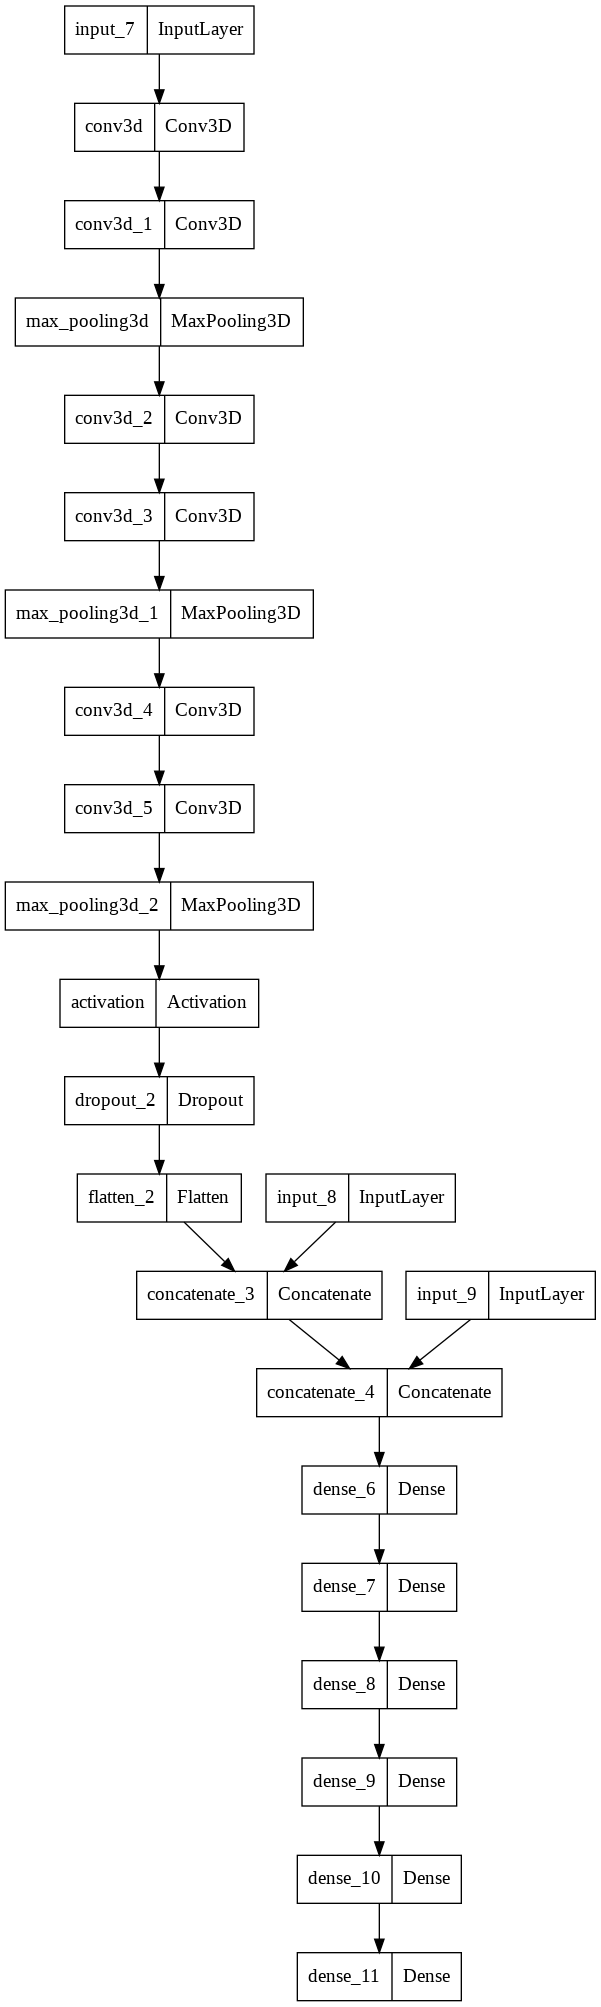

In [35]:
from keras.utils.vis_utils import plot_model

plot_model(model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False)